# 1. Data Fetching and Plotting

In [1]:
from IPF import run_kusto, solve
import pandas as pd
import dateutil.parser as dp
import matplotlib.pyplot as plt
import numpy as np

from azure.kusto.data.exceptions import KustoServiceError
from azure.kusto.data.helpers import dataframe_from_result_table
from azure.kusto.data import KustoClient, KustoConnectionStringBuilder, ClientRequestProperties

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True

In [2]:
T = 129597 # time steps in consideration
TAU = 5 # initialization time TODO: add Kusto query for this
alpha = 1 # cost of idle time
beta = 1 # cost of customer waiting time

STABLENESS = 5 # the pool size cannot change in X time steps
AGGREGATION = "30s" # tiem interval for each step

In [4]:
kusto_query = f"""
// Plot number of clusters rate, new
let start_time = datetime("2022-06-11 00:00");
let end_time = datetime("2022-07-20 01:02");
let region_pick_job = "Synapse-Job-Service1-Prod-EastUS";
let node_size = "Small";
let job_type = "Cluster";
JobSubmissionEvent
//| where JobType == job_type
//| where Tenant == region_pick_job
| where PreciseTimeStamp >= start_time and PreciseTimeStamp <= end_time and NodeSize =~ node_size
| project JobSubmittedAt=PreciseTimeStamp, WorkspaceName, ComputeName, JobId, NodeSize
| join kind=leftouter (
    StateChangeEvent
    | where PreciseTimeStamp >= start_time and PreciseTimeStamp <= end_time
    | where FromState == "Creation" and ToState == "Monitoring"
    | project ClusterReadyAt=PreciseTimeStamp, FromState, ToState, WorkspaceName, ComputeName, JobId) on WorkspaceName, ComputeName, JobId
| where isnotempty(ClusterReadyAt)
| join kind=leftouter(
    ClusterCreatedEvent
    | where PreciseTimeStamp >= start_time and PreciseTimeStamp <= end_time
    | project PreciseTimeStamp, WorkspaceName, ComputeName, JobId, DurationInSeconds) on WorkspaceName, ComputeName, JobId
| project JobSubmittedAt, ClusterReadyAt, WorkspaceName, ComputeName, JobId, ClusterReadyLatency=datetime_diff('second', ClusterReadyAt, JobSubmittedAt), DurationInSeconds
| project PreciseTimeStamp=JobSubmittedAt, ClusterReadyLatency
| extend ClusterCount = 1
| order by PreciseTimeStamp asc nulls first
| extend ClusterCountCumu = row_cumsum(ClusterCount)
| project PreciseTimeStamp, ClusterCountCumu, ClusterCount
| make-series sum(ClusterCount) default=0 on PreciseTimeStamp step 30s// by Tenant, MaxNodes, SkuName
"""
cluster = "https://analytics365prod.kusto.windows.net"
db = "Analytics365SparkPROD"
client_id = "f8c4efc4-cda5-4463-a7a6-4178ef046b9b"
client_secret = "75EK5Vloh~m--2n.u_q21swhG~nqNIRW0_" 
authority_id = "72f988bf-86f1-41af-91ab-2d7cd011db47"

kcsb = KustoConnectionStringBuilder.with_aad_application_key_authentication(
    cluster, 
    client_id, 
    client_secret, 
    authority_id)
client = KustoClient(kcsb)

arrival_rate = client.execute(db, kusto_query)
dataframe = dataframe_from_result_table(arrival_rate.primary_results[0])    

In [5]:
dataframe

sum_ClusterCount  \
0  [631, 425, 553, 272, 202, 159, 142, 117, 219, ...   

                                    PreciseTimeStamp  
0  [2022-06-11T00:00:00.0000000Z, 2022-06-11T00:0...

(112442, 2)


(array([19154.        , 19154.00694444, 19154.01388889, 19154.02083333,
        19154.02777778, 19154.03472222, 19154.04166667]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

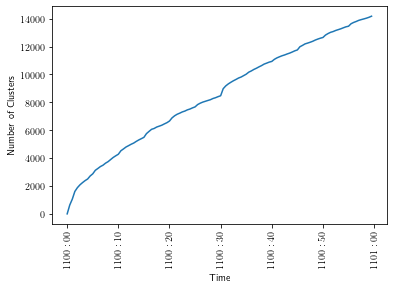

In [12]:
times = dataframe.iloc[0]["PreciseTimeStamp"]
demand = dataframe.iloc[0]["sum_ClusterCount"]
df = pd.DataFrame({"PreciseTimeStamp":times,
                   "sum_ClusterCount":demand})
print(df.shape)
# df = df.iloc[:T]
df["sum_ClusterCount"] = df["sum_ClusterCount"].astype(int)
df["Dt"] = df["sum_ClusterCount"].cumsum().shift(1).fillna(0)
df["time"] = df["PreciseTimeStamp"].apply(lambda x: dp.parse(x))
df = df.set_index("time")
plt.plot(df.head(120)["Dt"])
plt.xlabel("Time")
plt.ylabel("Number of Clusters")
plt.xticks(rotation = 90)

In [13]:
# df.to_csv(r"kusto_0711.csv")

# 2. Solve the optimal N

In [14]:
df = pd.read_csv(r"kusto_0711.csv")

In [15]:
df.iloc[0]

time                   2022-06-11 00:00:00+00:00
PreciseTimeStamp    2022-06-11T00:00:00.0000000Z
sum_ClusterCount                             631
Dt                                           0.0
Name: 0, dtype: object

In [16]:
df["time"] = pd.to_datetime(df["time"])

Solving in 29.40
OPTIMAL
Total idle time: 5074395.000000
Total waiting time: 5626048.000000


F:\Tools\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


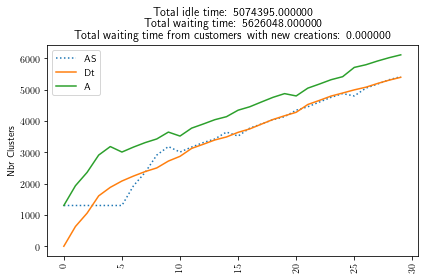

In [17]:
df_result = solve(df,len(df)-10,AGGREGATION,TAU,alpha,beta,STABLENESS,plot=True,plot_t=30)

In [18]:
df_result.head(10)
# df_result.to_csv("tmp0711_paper.csv")

time              PreciseTimeStamp  sum_ClusterCount  \
0 2022-06-11 00:00:00+00:00  2022-06-11T00:00:00.0000000Z               631   
1 2022-06-11 00:00:30+00:00  2022-06-11T00:00:30.0000000Z               425   
2 2022-06-11 00:01:00+00:00  2022-06-11T00:01:00.0000000Z               553   
3 2022-06-11 00:01:30+00:00  2022-06-11T00:01:30.0000000Z               272   
4 2022-06-11 00:02:00+00:00  2022-06-11T00:02:00.0000000Z               202   
5 2022-06-11 00:02:30+00:00  2022-06-11T00:02:30.0000000Z               159   
6 2022-06-11 00:03:00+00:00  2022-06-11T00:03:00.0000000Z               142   
7 2022-06-11 00:03:30+00:00  2022-06-11T00:03:30.0000000Z               117   
8 2022-06-11 00:04:00+00:00  2022-06-11T00:04:00.0000000Z               219   
9 2022-06-11 00:04:30+00:00  2022-06-11T00:04:30.0000000Z               151   

   CumulativeClusterDemand  PoolClusterCreated  T_Idle  T_Waiting  \
0                      0.0              1302.0  1302.0        0.0   
1                    631.0              1302.0   671.0        0.0   
2                   1056.0              1302.0   246.0        0.0   
3                   1609.0              1302.0     0.0      307.0   
4                   1881.0              1302.0     0.0      579.0   
5                   2083.0              1302.0     0.0      781.0   
6                   2242.0              1933.0     0.0      309.0   
7                   2384.0              2358.0     0.0       26.0   
8                   2501.0              2911.0   410.0        0.0   
9                   2720.0              3183.0   463.0        0.0   

   PoolClusterRequested  OptimalPoolSize  
0                1302.0           1302.0  
1                1933.0           1302.0  
2                2358.0           1302.0  
3                2911.0           1302.0  
4                3183.0           1302.0  
5                3008.0            925.0  
6                3167.0            925.0  
7                3309.0            925.0  
8                3426.0            925.0  
9                3645.0            925.0

In [19]:
df_result_all = df_result.copy()

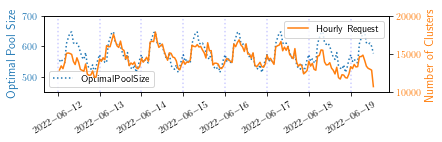

In [57]:
df_result = df_result_all.reset_index().iloc[3000:24699]
df_result["Hour"] = df_result["time"].apply(lambda x: x.replace(second=0, microsecond=0, minute=0, hour=x.hour))
df_result_avg = df_result.groupby("Hour").mean()
df_result_sum = df_result.groupby("Hour").sum()

fig, ax1 = plt.subplots(figsize=(6.25,2))
color = 'tab:blue'
ax1.set_ylabel('Optimal Pool Size', color=color, fontsize=12)
ax1.plot(df_result_avg["OptimalPoolSize"], linestyle = ":", color=color, label = "OptimalPoolSize")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(450,700)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:orange'
ax2.set_ylabel('Number of Clusters', color=color,fontsize=12)  # we already handled the x-label with ax1
ax2.plot(df_result_sum["sum_ClusterCount"], color=color, label = "Hourly Request")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc = "upper right")
ax2.set_ylim(10000,20000)
ax1.tick_params (axis='x', labelrotation= 30) 
ax1.legend(loc = "lower left")
for time_x in pd.to_datetime([
    "2022-06-12",
    "2022-06-13",
    "2022-06-14",
    "2022-06-15",
    "2022-06-16",
    "2022-06-17",
    "2022-06-18",
    "2022-06-19"]):
    ax1.axvline(time_x,color="b",linestyle=":",alpha=0.2)
plt.tight_layout()
plt.savefig("poolsize2.pdf")

In [58]:
df_result.set_index("time").iloc[580:1000]

index              PreciseTimeStamp  \
time                                                             
2022-06-12 05:50:00+00:00   3580  2022-06-12T05:50:00.0000000Z   
2022-06-12 05:50:30+00:00   3581  2022-06-12T05:50:30.0000000Z   
2022-06-12 05:51:00+00:00   3582  2022-06-12T05:51:00.0000000Z   
2022-06-12 05:51:30+00:00   3583  2022-06-12T05:51:30.0000000Z   
2022-06-12 05:52:00+00:00   3584  2022-06-12T05:52:00.0000000Z   
...                          ...                           ...   
2022-06-12 09:17:30+00:00   3995  2022-06-12T09:17:30.0000000Z   
2022-06-12 09:18:00+00:00   3996  2022-06-12T09:18:00.0000000Z   
2022-06-12 09:18:30+00:00   3997  2022-06-12T09:18:30.0000000Z   
2022-06-12 09:19:00+00:00   3998  2022-06-12T09:19:00.0000000Z   
2022-06-12 09:19:30+00:00   3999  2022-06-12T09:19:30.0000000Z   

                           sum_ClusterCount  CumulativeClusterDemand  \
time                                                                   
2022-06-12 05:50:00+00:00               187                 398381.0   
2022-06-12 05:50:30+00:00               177                 398568.0   
2022-06-12 05:51:00+00:00                85                 398745.0   
2022-06-12 05:51:30+00:00                61                 398830.0   
2022-06-12 05:52:00+00:00                78                 398891.0   
...                                     ...                      ...   
2022-06-12 09:17:30+00:00               106                 451466.0   
2022-06-12 09:18:00+00:00               117                 451572.0   
2022-06-12 09:18:30+00:00                83                 451689.0   
2022-06-12 09:19:00+00:00                83                 451772.0   
2022-06-12 09:19:30+00:00                88                 451855.0   

                           PoolClusterCreated  T_Idle  T_Waiting  \
time                                                               
2022-06-12 05:50:00+00:00            398478.0    97.0        0.0   
2022-06-12 05:50:30+00:00            398544.0     0.0       24.0   
2022-06-12 05:51:00+00:00            398648.0     0.0       97.0   
2022-06-12 05:51:30+00:00            398739.0     0.0       91.0   
2022-06-12 05:52:00+00:00            398842.0     0.0       49.0   
...                                       ...     ...        ...   
2022-06-12 09:17:30+00:00            451271.0     0.0      195.0   
2022-06-12 09:18:00+00:00            451521.0     0.0       51.0   
2022-06-12 09:18:30+00:00            451690.0     1.0        0.0   
2022-06-12 09:19:00+00:00            451809.0    37.0        0.0   
2022-06-12 09:19:30+00:00            451890.0    35.0        0.0   

                           PoolClusterRequested  OptimalPoolSize  \
time                                                               
2022-06-12 05:50:00+00:00              398789.0            408.0   
2022-06-12 05:50:30+00:00              398976.0            408.0   
2022-06-12 05:51:00+00:00              399153.0            408.0   
2022-06-12 05:51:30+00:00              399238.0            408.0   
2022-06-12 05:52:00+00:00              399299.0            408.0   
...                                         ...              ...   
2022-06-12 09:17:30+00:00              452064.0            598.0   
2022-06-12 09:18:00+00:00              452170.0            598.0   
2022-06-12 09:18:30+00:00              452287.0            598.0   
2022-06-12 09:19:00+00:00              452370.0            598.0   
2022-06-12 09:19:30+00:00              452453.0            598.0   

                                               Hour  
time                                                 
2022-06-12 05:50:00+00:00 2022-06-12 05:00:00+00:00  
2022-06-12 05:50:30+00:00 2022-06-12 05:00:00+00:00  
2022-06-12 05:51:00+00:00 2022-06-12 05:00:00+00:00  
2022-06-12 05:51:30+00:00 2022-06-12 05:00:00+00:00  
2022-06-12 05:52:00+00:00 2022-06-12 05:00:00+00:00  
...                                             ...  
2022-06-12 09:17:30+00:00 202

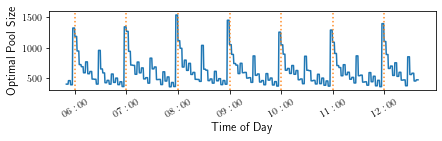

In [59]:
import matplotlib.dates as mdates
fig, ax1 = plt.subplots(figsize=(6.25, 2))
ax1.plot(df_result.set_index("time").iloc[580:1400]["OptimalPoolSize"])
ax1.set_ylabel('Optimal Pool Size',fontsize=12)  # we already handled the x-label with ax1
ax1.set_xlabel('Time of Day',fontsize=12)  # we already handled the x-label with ax1
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
for time_x in pd.to_datetime([
    "2022-06-12 06:00",
    "2022-06-12 07:00",
    "2022-06-12 08:00",
    "2022-06-12 09:00",
    "2022-06-12 10:00",
    "2022-06-12 11:00",
    "2022-06-12 12:00"]):
    ax1.axvline(time_x,color="tab:orange",linestyle=":",alpha=0.9)
ax1.tick_params (axis='x', labelrotation= 30) 
plt.tight_layout()
plt.savefig("poolsize3.pdf")

In [60]:
df_result.head()

index                      time              PreciseTimeStamp  \
3000   3000 2022-06-12 01:00:00+00:00  2022-06-12T01:00:00.0000000Z   
3001   3001 2022-06-12 01:00:30+00:00  2022-06-12T01:00:30.0000000Z   
3002   3002 2022-06-12 01:01:00+00:00  2022-06-12T01:01:00.0000000Z   
3003   3003 2022-06-12 01:01:30+00:00  2022-06-12T01:01:30.0000000Z   
3004   3004 2022-06-12 01:02:00+00:00  2022-06-12T01:02:00.0000000Z   

      sum_ClusterCount  CumulativeClusterDemand  PoolClusterCreated  T_Idle  \
3000               588                 331777.0            332693.0   916.0   
3001               455                 332365.0            332776.0   411.0   
3002               248                 332820.0            332841.0    21.0   
3003               190                 333068.0            332890.0     0.0   
3004               176                 333258.0            332960.0     0.0   

      T_Waiting  PoolClusterRequested  OptimalPoolSize  \
3000        0.0              332747.0            970.0   
3001        0.0              333335.0            970.0   
3002        0.0              333790.0            970.0   
3003      178.0              334038.0            970.0   
3004      298.0              334228.0            970.0   

                          Hour  
3000 2022-06-12 01:00:00+00:00  
3001 2022-06-12 01:00:00+00:00  
3002 2022-06-12 01:00:00+00:00  
3003 2022-06-12 01:00:00+00:00  
3004 2022-06-12 01:00:00+00:00

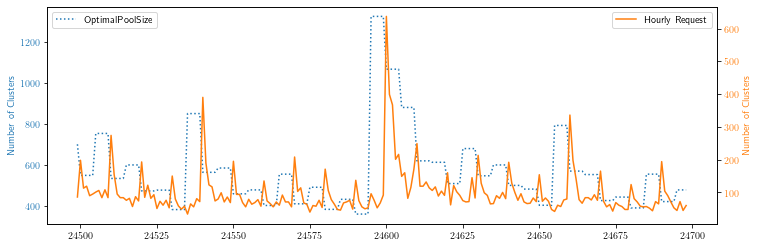

In [61]:
# df_result = df_result.set_index("time")
fig, ax1 = plt.subplots(figsize=(12,4))
color = 'tab:blue'
ax1.set_ylabel('Number of Clusters', color=color)
ax1.plot(df_result.tail(200)["OptimalPoolSize"], linestyle = ":", color=color, label = "OptimalPoolSize")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc = "upper left")
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('Number of Clusters', color=color)  # we already handled the x-label with ax1
ax2.plot(df_result.tail(200)["sum_ClusterCount"], color=color, label = "Hourly Request")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc = "upper right")

# 3. Explore trade-offs

Total original waiting time: 12992735


F:\Tools\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
F:\Tools\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
F:\Tools\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

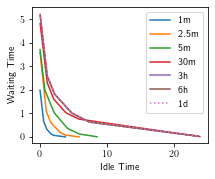

In [64]:
waiting_old = sum(df_result["sum_ClusterCount"]) * TAU
print("Total original waiting time: %d" %waiting_old)
idle_all = []
waiting_all = []
label_map = {2:"1m", 5:"2.5m", 10:"5m", 60:"30m", 360:"3h", 720:"6h", 2880:"1d"}
plt.figure(figsize=(3.15,2.5))
for STABLENESS_ in [2, 5, 10, 60, 360, 720, 2880]:
    idle = []
    waiting = []
    for beta_ in [0.1,1,2,5,10,100]:
        df_result_ = solve(df,len(df),AGGREGATION,TAU,alpha,beta_,STABLENESS_,plot=False,plot_t=30, verbose=False)
        idle.append(sum(df_result_["T_Idle"]))
        waiting.append(sum(df_result_["T_Waiting"]))
    if STABLENESS_ == 2880:
        if AGGREGATION == "30s":
            plt.plot(np.array(idle)/sum(df_result["sum_ClusterCount"])/2,
                     np.array(waiting)/sum(df_result["sum_ClusterCount"])/2, 
                     label=label_map[STABLENESS_], linestyle = ":")
    else:
        if AGGREGATION == "30s":
            plt.plot(np.array(idle)/sum(df_result["sum_ClusterCount"])/2,
                     np.array(waiting)/sum(df_result["sum_ClusterCount"])/2, 
                     label=label_map[STABLENESS_])
    idle_all.append(np.array(idle)/sum(df_result["sum_ClusterCount"])/2)
    waiting_all.append(np.array(waiting)/sum(df_result["sum_ClusterCount"])/2)
plt.xlabel("Idle Time")
plt.ylabel("Waiting Time")   
plt.legend()
plt.savefig("tradeoffs.pdf")

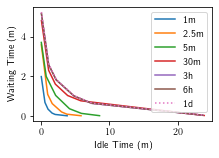

In [69]:
plt.figure(figsize=(3.15,2.3))
count_i = 0
for STABLENESS_ in [2, 5, 10, 60, 360, 720, 2880]:


    if STABLENESS_ == 2880:
        if AGGREGATION == "30s":
            plt.plot(idle_all[count_i],
                     waiting_all[count_i], 
                     label=label_map[STABLENESS_], linestyle = ":")
    else:
        if AGGREGATION == "30s":
            plt.plot(idle_all[count_i],
                     waiting_all[count_i],
                     label=label_map[STABLENESS_])
    count_i += 1
plt.xlabel("Idle Time (m)")
plt.ylabel("Waiting Time (m)")   
plt.legend()
plt.tight_layout()
plt.savefig("tradeoffs.pdf")

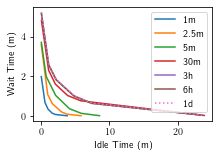

In [70]:
plt.figure(figsize=(3.15,2.3))
count_i = 0
for STABLENESS_ in [2, 5, 10, 60, 360, 720, 2880]:


    if STABLENESS_ == 2880:
        if AGGREGATION == "30s":
            plt.plot(idle_all[count_i],
                     waiting_all[count_i], 
                     label=label_map[STABLENESS_], linestyle = ":")
    else:
        if AGGREGATION == "30s":
            plt.plot(idle_all[count_i],
                     waiting_all[count_i],
                     label=label_map[STABLENESS_])
    count_i += 1
plt.xlabel("Idle Time (m)")
plt.ylabel("Wait Time (m)")   
plt.legend()
plt.tight_layout()
plt.savefig("tradeoffs1.pdf")

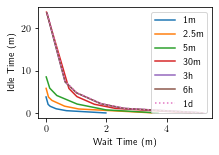

In [71]:
plt.figure(figsize=(3.15,2.3))
count_i = 0
for STABLENESS_ in [2, 5, 10, 60, 360, 720, 2880]:


    if STABLENESS_ == 2880:
        if AGGREGATION == "30s":
            plt.plot(
                     waiting_all[count_i], 
                idle_all[count_i],
                     label=label_map[STABLENESS_], linestyle = ":")
    else:
        if AGGREGATION == "30s":
            plt.plot(
                     waiting_all[count_i],
                idle_all[count_i],
                     label=label_map[STABLENESS_])
    count_i += 1
plt.ylabel("Idle Time (m)")
plt.xlabel("Wait Time (m)")   
plt.legend()
plt.tight_layout()
plt.savefig("tradeoffs2.pdf")

Solving in 904.69
OPTIMAL
Total idle time: 220498.000000
Total waiting time: 427235.000000


C:\Users\yiwzh\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\yiwzh\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


PreciseTimeStamp  sum_ClusterCount  \
time                                                                        
2022-02-01 00:00:00+00:00  2022-02-01T00:00:00.0000000Z                10   
2022-02-01 00:00:30+00:00  2022-02-01T00:00:30.0000000Z                15   
2022-02-01 00:01:00+00:00  2022-02-01T00:01:00.0000000Z                10   
2022-02-01 00:01:30+00:00  2022-02-01T00:01:30.0000000Z                 7   
2022-02-01 00:02:00+00:00  2022-02-01T00:02:00.0000000Z                 1   

                           CumulativeClusterDemand  PoolClusterCreated  \
time                                                                     
2022-02-01 00:00:00+00:00                      0.0                 9.0   
2022-02-01 00:00:30+00:00                     10.0                 9.0   
2022-02-01 00:01:00+00:00                     25.0                 9.0   
2022-02-01 00:01:30+00:00                     35.0                 9.0   
2022-02-01 00:02:00+00:00                     42.0                 9.0   

                           T_Idle  T_Waiting  PoolClusterRequested  \
time                                                                 
2022-02-01 00:00:00+00:00     9.0        0.0                   9.0   
2022-02-01 00:00:30+00:00     0.0        1.0                  19.0   
2022-02-01 00:01:00+00:00     0.0       16.0                  34.0   
2022-02-01 00:01:30+00:00     0.0       26.0                  44.0   
2022-02-01 00:02:00+00:00     0.0       33.0                  51.0   

                           OptimalPoolSize  
time                                        
2022-02-01 00:00:00+00:00              9.0  
2022-02-01 00:00:30+00:00              9.0  
2022-02-01 00:01:00+00:00              9.0  
2022-02-01 00:01:30+00:00              9.0  
2022-02-01 00:02:00+00:00              9.0

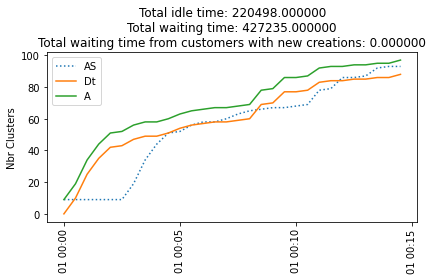

In [11]:
df_result = solve(df,T,AGGREGATION,TAU,1,1,2880,plot=True,plot_t=30)
df_result.head()